# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib inline
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [3]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=901)
    return corrected_lc

In [4]:
### RUN THIS - it will take a while.
#stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
#stitched_lc

In [5]:
#clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
#clc.scatter();

In [6]:
#clc.to_fits('clc.fits', overwrite=True)

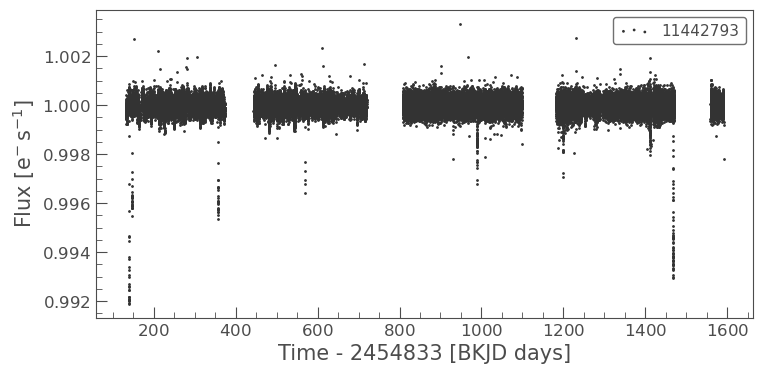

In [7]:
clc = lk.KeplerLightCurve.read('clc.fits', quality_bitmask='none')
clc.scatter();

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


In [8]:
# YOUR CODE HERE
from matplotlib.ticker import AutoMinorLocator

def plotutils(ax, xscale='linear', yscale='linear'): # Standard plotting utility
   ax.xaxis.set_minor_locator(AutoMinorLocator())
   ax.yaxis.set_minor_locator(AutoMinorLocator())
   ax.tick_params(which='both', direction='in', right=True, top=True)
   ax.set_xscale(xscale)
   ax.set_yscale(yscale)
   return


period = np.arange(50, 500, 0.01)
prdgm = clc.to_periodogram(method='bls', period=period)
#prdgm.plot()

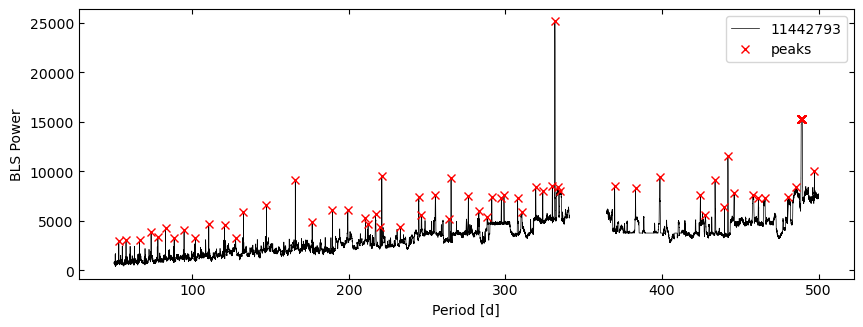

In [9]:
power = prdgm.power.copy()
mask = np.zeros_like(power)
mask[29100:31465] = 1
power = np.ma.masked_array(power, mask=mask)
period = np.ma.masked_array(period, mask=mask)
peaks = find_peaks(power, prominence=2000)[0]

# Plot
fig = plt.figure(figsize=(10, 3.5))
ax = fig.add_subplot()
plotutils(ax)

ax.plot(period, power, '-k', linewidth=0.5, label='11442793')
ax.plot(period[peaks], power[peaks], 'xr', linewidth=0.5, label='peaks')
ax.set_xlabel('Period [d]')
ax.set_ylabel('BLS Power')
#ax.set_xlim(340, 370)
ax.legend()
plt.show()

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [10]:
# YOUR CODE HERE
tt = prdgm.transit_time.value
tt = np.ma.masked_array(tt, mask=mask)

data = [period[peaks], power[peaks], tt[peaks]]
names=('Period', 'Power', 'Transit Time')
tab = at.QTable(data, names=names)
tab.sort('Power')

print(tab)

      Period             Power           Transit Time   
                                                        
------------------ ------------------ ------------------
 53.04999999999939 2922.3648747654856 140.56764779216806
57.669999999998474 3055.1432772454923 140.43764779216804
 66.31999999999675  3058.388726711478 140.43764779216804
127.67999999998455  3223.226389330744 140.54264779216805
102.01999999998965 3264.8875127051615 140.54264779216805
 88.41999999999236 3279.8125909497603 140.54264779216805
               ...                ...                ...
489.03999999991265 15323.450195199204 140.54264779216805
489.01999999991267 15323.450195199204 140.54264779216805
488.95999999991267 15323.450195199204 140.54264779216805
489.44999999991256 15323.450195199204 140.54264779216805
489.11999999991264 15323.450195199204 140.54264779216805
 488.9399999999127 15323.450195199204 140.54264779216805
  331.569999999944 25161.143444572288 140.54264779216805
Length = 133 rows


# Q2. b. Next sort the list of periods from longest to shortest. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [11]:
# YOUR CODE HERE
tab.sort('Period')
tab.reverse()
tab.remove_rows(slice(0,60))

In [12]:
toremove = []
cons = 0.1
for n, pd in enumerate(tab['Period']):
    for chpd in tab['Period'][n:]:
        if chpd > ((pd / 2.) - cons) and chpd < ((pd / 2.) + cons):
            toremove.append(n)
        elif chpd > ((pd / 3.) - cons) and chpd < ((pd / 3.) + cons):
            toremove.append(n)

taba = tab
taba.remove_rows(toremove)
tabs = []
for n in range(4):
    taba = taba[taba['Period'] > n*100]
    tabs.append(taba[taba['Period'] <= (n+1)*100])
    tabs[n].sort('Power')
    tabs[n].reverse()
perpow = []
print('Period range: four highest peaks (ascending)')
for n in range(4):
    stuff = np.sort(tabs[n]['Period'][:4])
    sting = ''
    if n == 0:
        sting += '  '
    sting += str(n *100) + '-' + str((n+1) *100) + 'd: %0.2f, %0.2f, %0.2f, %0.2f'
    print(sting % tuple(stuff))
    perpow.append(stuff)
perpow = np.asarray(perpow)

Period range: four highest peaks (ascending)
  0-100d: 73.68, 78.02, 82.89, 94.74
100-200d: 110.52, 120.57, 176.52, 199.33
200-300d: 244.67, 276.29, 291.19, 299.02
300-400d: 319.34, 329.94, 333.87, 369.76


# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

In [13]:
# YOUR CODE HERE
def refine_period(pd):
    period = np.arange(pd-5, pd+5, 0.0002)
    prdgm2 = clc.to_periodogram(method='bls', period=period)

    power = prdgm2.power.copy()
    peaks = find_peaks(power, prominence=2000)[0]
    refpd = period[peaks][np.argmax(power[peaks])]
    return refpd


perpow = perpow.flatten()
refperpow = []
for pp in perpow:
    refperpow.append(refine_period(pp))
refperpow = np.asarray(refperpow)
rpp = np.reshape(refperpow, (4, 4))

In [14]:
print('Period range: four (refined) highest peaks (ascending)')
for n in range(4):
    sting = ''
    if n == 0:
        sting += '  '
    sting += str(n *100) + '-' + str((n+1) *100) + 'd: %0.2f, %0.2f, %0.2f, %0.2f'
    print(sting % tuple(rpp[n]))
print('One of the peaks from 0-100d are within 5d of each other, so the algorithm selects the higher (in power) of the two.  This seems, at face value, reasonable.')

Period range: four (refined) highest peaks (ascending)
  0-100d: 73.68, 82.89, 82.89, 94.73
100-200d: 110.52, 120.57, 176.52, 199.32
200-300d: 244.67, 276.29, 291.24, 299.02
300-400d: 319.35, 331.57, 331.57, 369.75
One of the peaks from 0-100d are within 5d of each other, so the algorithm selects the higher (in power) of the two.  This seems, at face value, reasonable.


# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

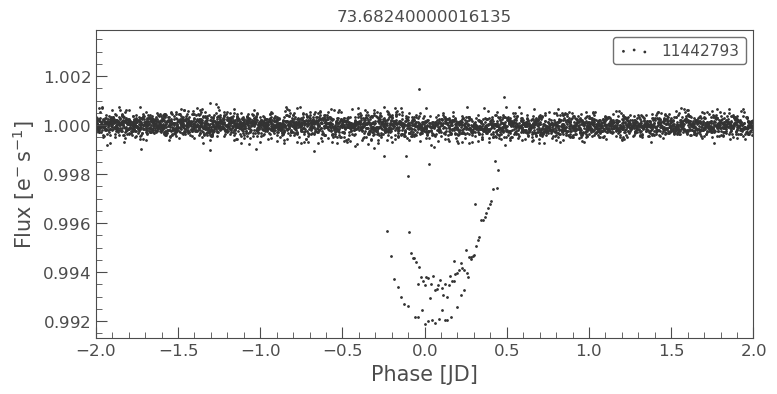

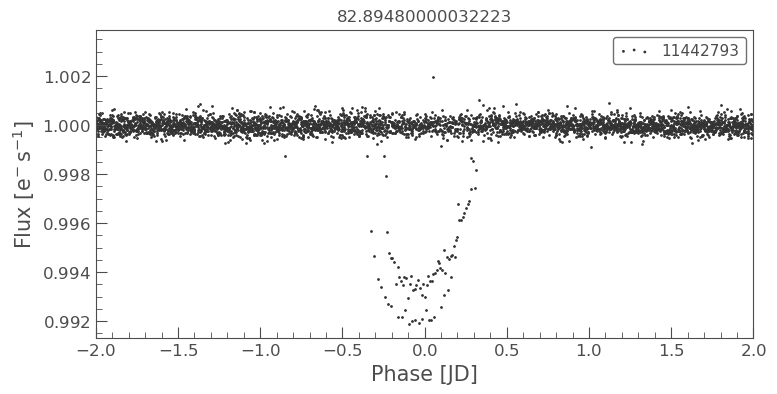

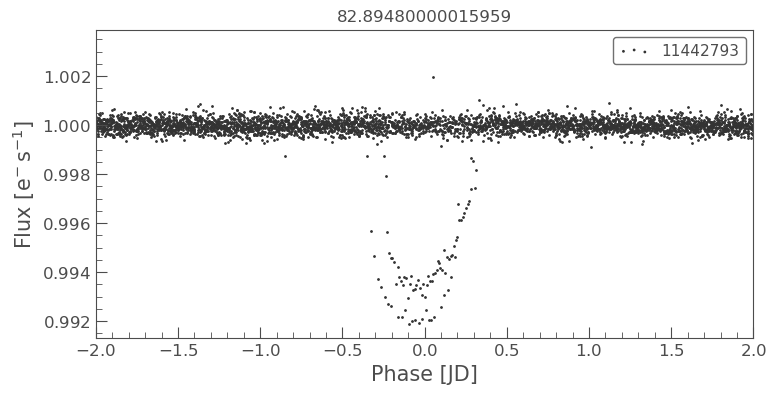

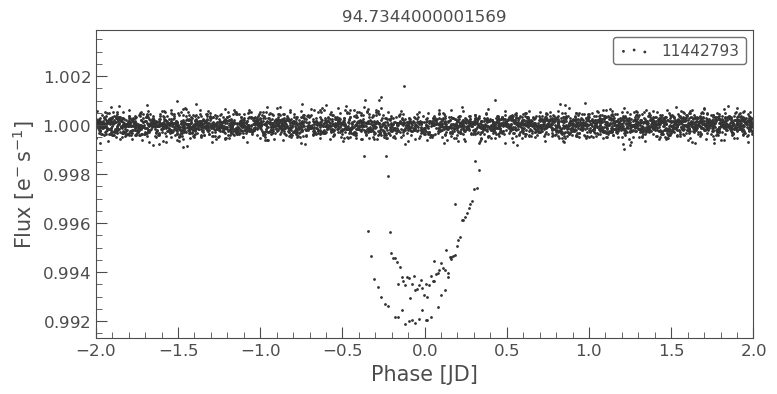

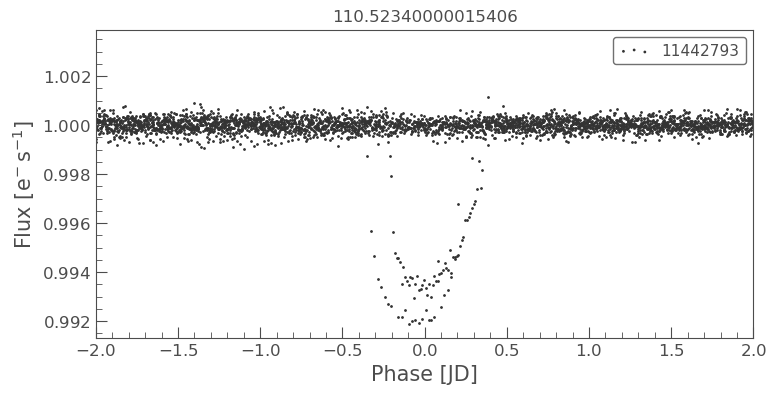

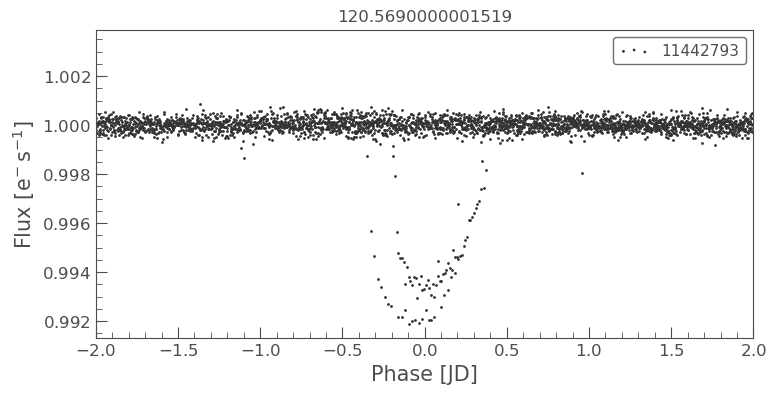

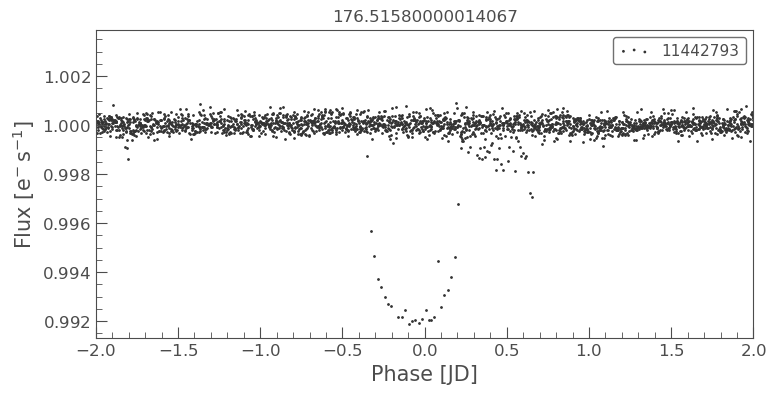

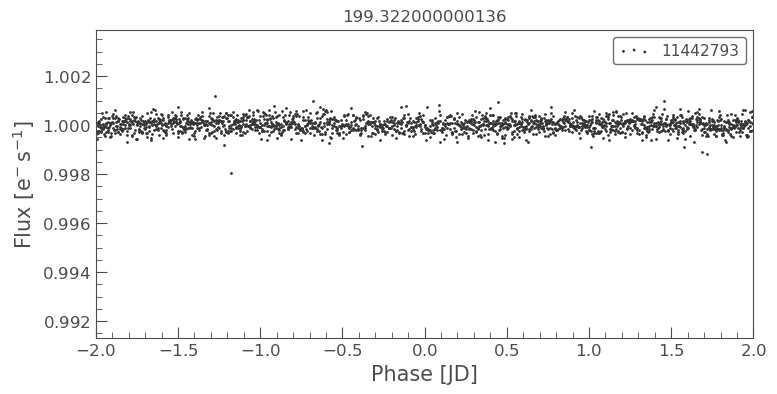

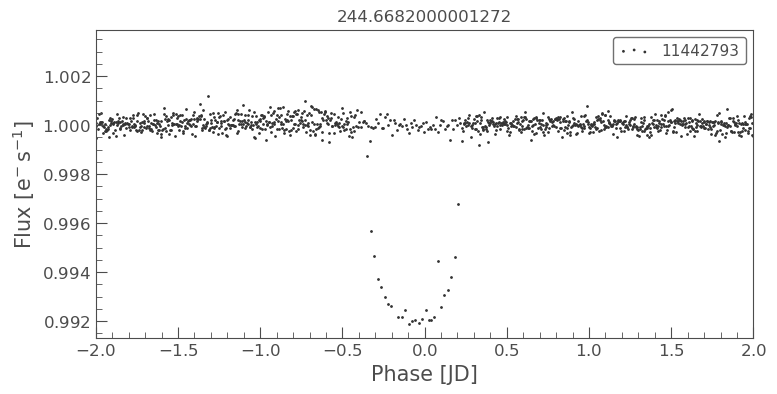

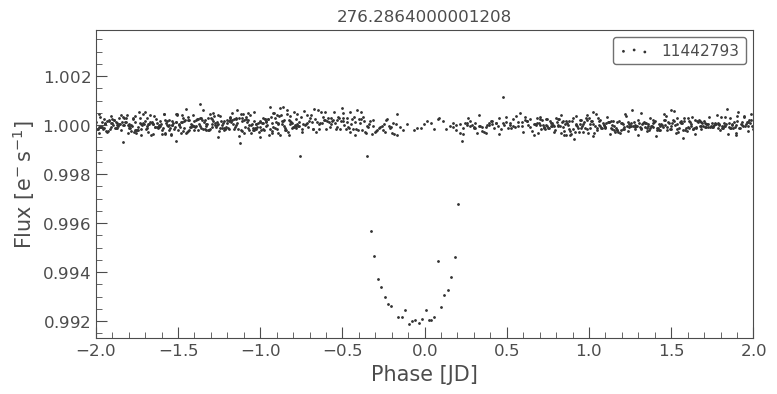

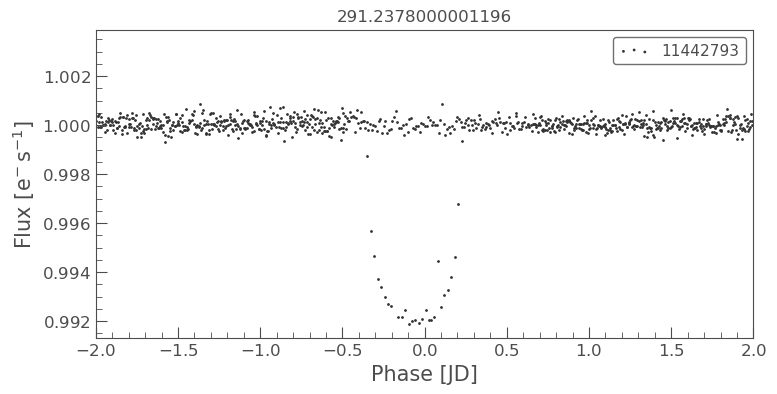

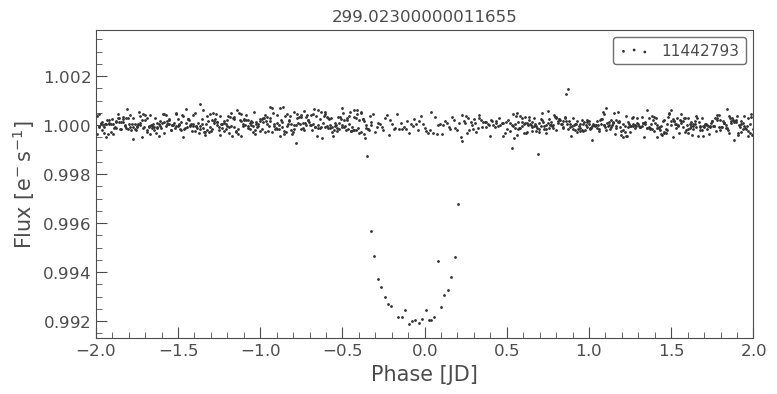

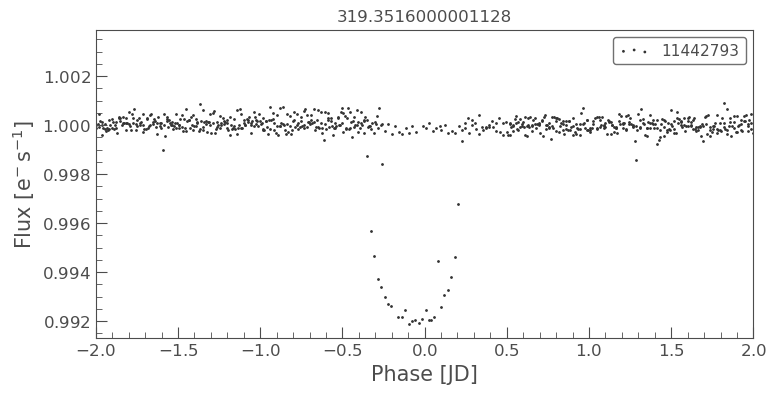

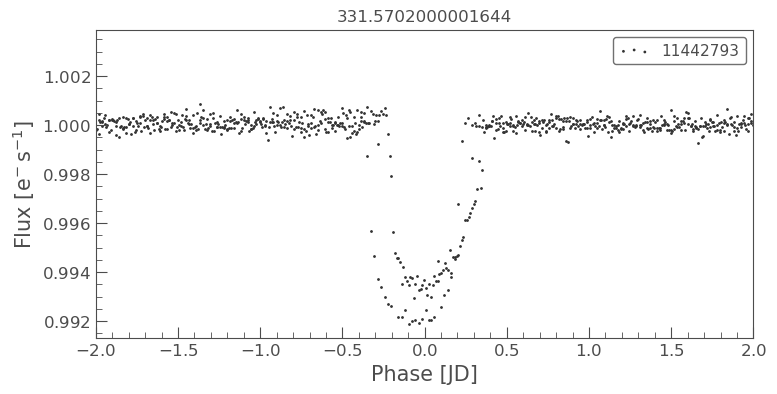

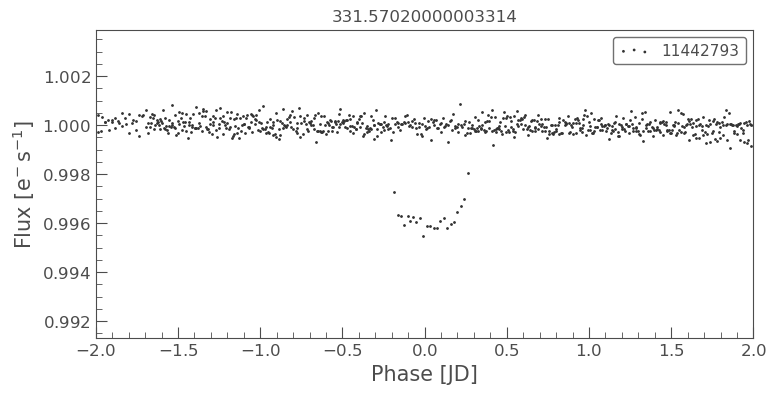

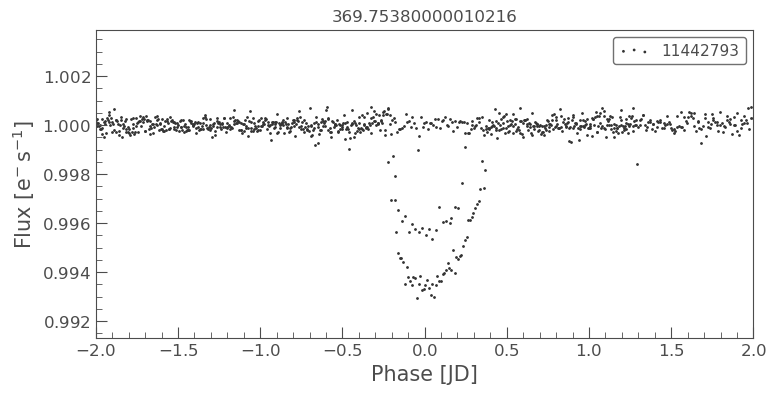

In [15]:
# YOUR CODE HERE
rpp = rpp.flatten()
ttpow = []
for n in range(4):
    stuff = np.sort(tabs[n]['Transit Time'][:4])
    ttpow.append(stuff)
ttpow = np.asarray(ttpow).flatten() 
#print(ttpow)
for i in range(len(rpp)):
    ax = clc.fold(period=rpp[i], epoch_time=ttpow[i]).scatter();
    ax.set_xlim(-2, 2)
    ax.set_title(rpp[i])